# Demo for test functions for all kind of data processing

## Tasks:
* Detect events:
    * Pitcher:
        * first movement
        * ball release
    * Batter:
        * Foot highest, foot back to ground
        * First step (when starting to run)
        
Please change in next cell the path to the main folder of the repository

In [1]:
import sys
sys.path.append("..")
path_to_models = os.path.join("..", "saved_models")

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy as sp
import scipy.stats
import matplotlib.pylab as plt
import json
from os import listdir
import cv2
import time
import ast
import json
from run_events import Runner
from test import test
# import matplotlib.pylab as plt
#from notebooks.code_to_json import from_json

from tools import Tools
from test import test
# path_outputs = "/Volumes/Nina Backup/finished_outputs/"
# test_json_files = "/Volumes/Nina Backup/high_quality_outputs/"
# test_data_path = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/"
# save =  "/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/saved_models/pitch_type_svcf"

# import functions:
# first_move_batter_gradient, first_move_batter_NN, release_frame_conv_net, release_frame_2Dfrom_video, foot_to_ground
from detect_event import *

In [5]:
from fmo_detection import *
joints_list = ["right_shoulder", "right_elbow", "right_wrist", "left_shoulder","left_elbow", "left_wrist",
        "right_hip", "right_knee", "right_ankle", "left_hip", "left_knee", "left_ankle", "neck ",
        "right_eye", "right_ear","left_eye", "left_ear"]

/Users/ninawiedemann/anaconda/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)


## Get data

In [4]:
example = "demo_data/example_1" # f4ea3410-f559-464f-acb0-74133d7742e3
pitcher = from_json(example+"_pitcher.json")
batter = from_json(example+"_batter.json")
with open(example+"_video_batter.json", "r") as infile:
    videos_b = json.load(infile)
with open(example+"_video_pitcher.json", "r") as infile:
    videos_p = json.load(infile)
with open(example+"_labels.json", "r") as infile:
    labels = json.load(infile)

## Visualize pitcher and batter joints

-------------------- batter ------------------------


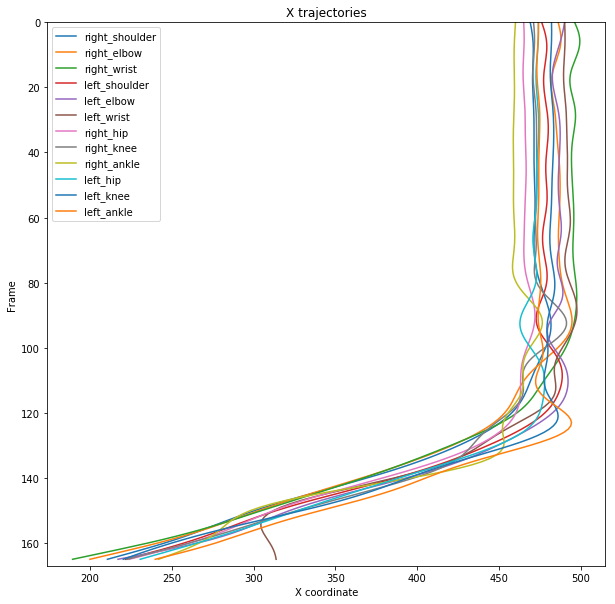

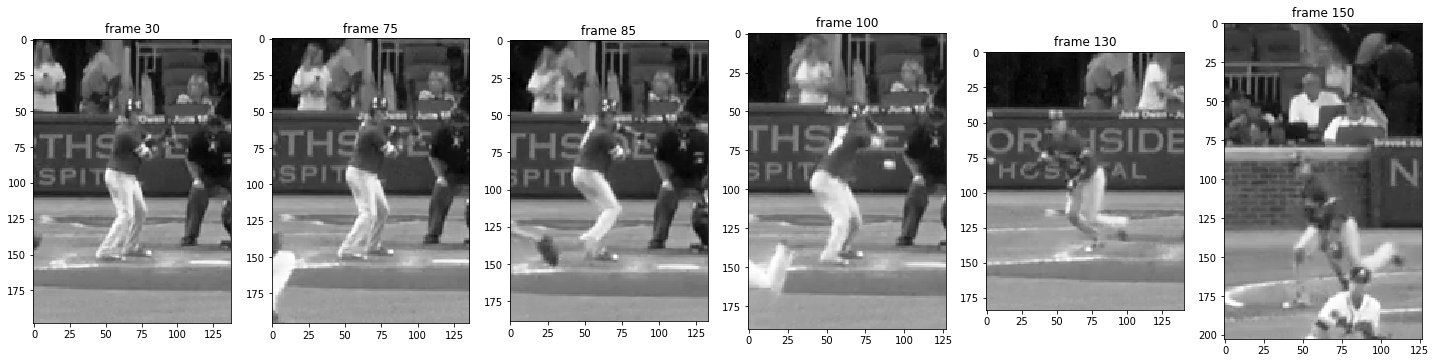

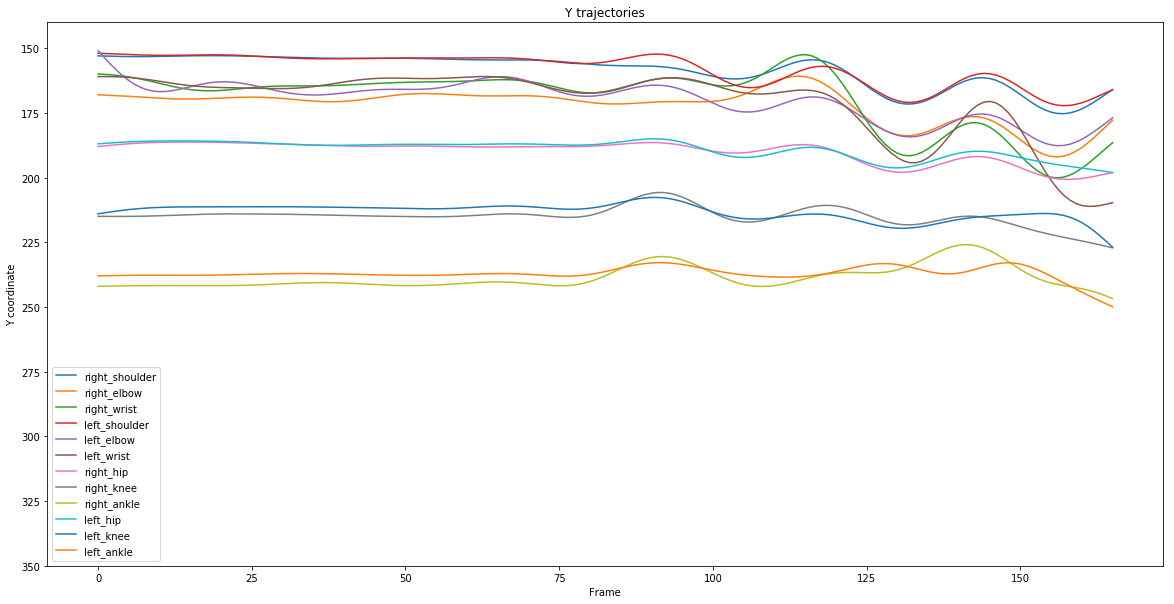

-------------------- pitcher ------------------------


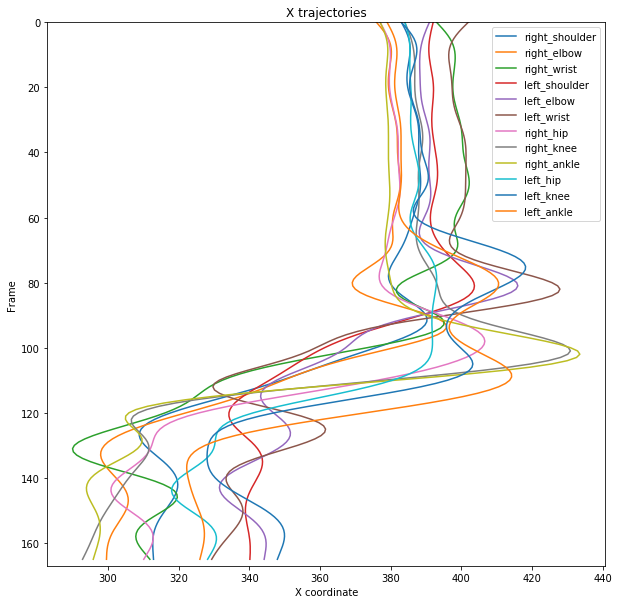

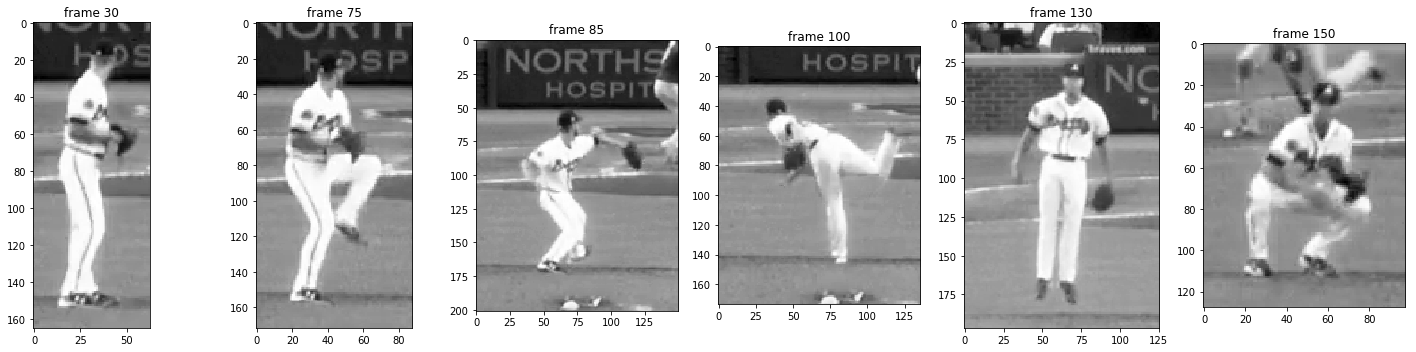

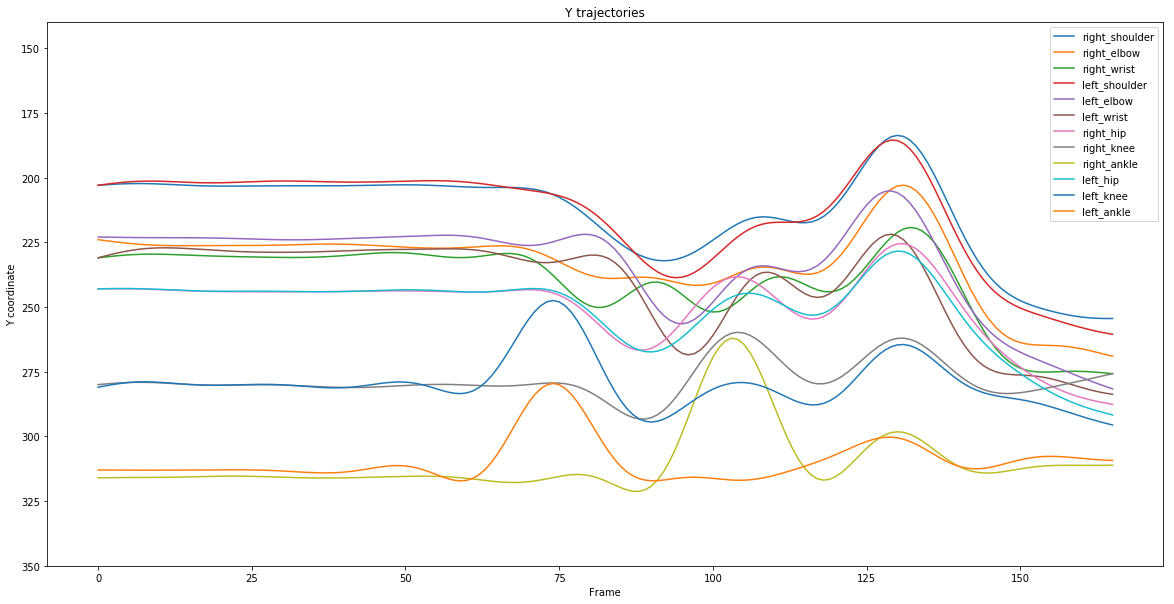

In [5]:
for video, person in zip(["videos_b", "videos_p"], ["batter", "pitcher"]):
    print("--------------------", person, "------------------------")
    plt.figure(figsize = (10,10))
    for j in joints_list[:12]:
        plt.plot(eval(person)[:,joints_list.index(j), 0], np.arange(0,len(eval(person)),1), label = j)
    plt.title("X trajectories")
    plt.ylim(167,0)
    plt.ylabel("Frame")
    plt.xlabel("X coordinate")
    plt.legend()
    plt.show()

    # Plot video frames to visualize maxima in X coordinates
    show_frames = [30, 75, 85, 100, 130, 150]
    fig = plt.figure(figsize=(20, 5))
    for ind, i in enumerate(show_frames):
        ax = fig.add_subplot(1,len(show_frames),ind+1)
        plt.imshow(eval(video)[i])
        plt.title("frame "+str(i))
        plt.gray()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize = (20,10))
    for j in joints_list[:12]: #[one_joint]: 
        plt.plot(eval(person)[:,joints_list.index(j), 1], label = j)
    plt.legend()
    plt.ylim(350, 140)
    plt.ylabel("Y coordinate")
    plt.xlabel("Frame")
    plt.title("Y trajectories")
    plt.show()

## Release frame: 

First neural network has sequence of 100 frames joint trajectory as input and 
detectes from joints which one is most likeley to be the release frame

Second neural network outputs probability for a single IMAGE to be a release position, and outputs the one with highest probability as the release frame

INFO:tensorflow:Restoring parameters from /Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/saved_models/release_frame_smooth
time for nr labels 0.02916097640991211
INFO:tensorflow:Restoring parameters from /Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/saved_models/release_frame_smooth
time for nr labels 0.02883601188659668
INFO:tensorflow:Restoring parameters from /Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/saved_models/release_frame_smooth
time for nr labels 0.027479171752929688
[78, 86, 112] model smooth mean 92.0
INFO:tensorflow:Restoring parameters from /Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/saved_models/release_frame_general
time for nr labels 0.06415820121765137
INFO:tensorflow:Restoring parameters from /Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/saved_models/release_frame_general
time for nr labels 0.05375409126281738
INFO:tensorflow:Restoring parameters from /Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/saved_models/release_frame_general
time for nr labels 0.08539

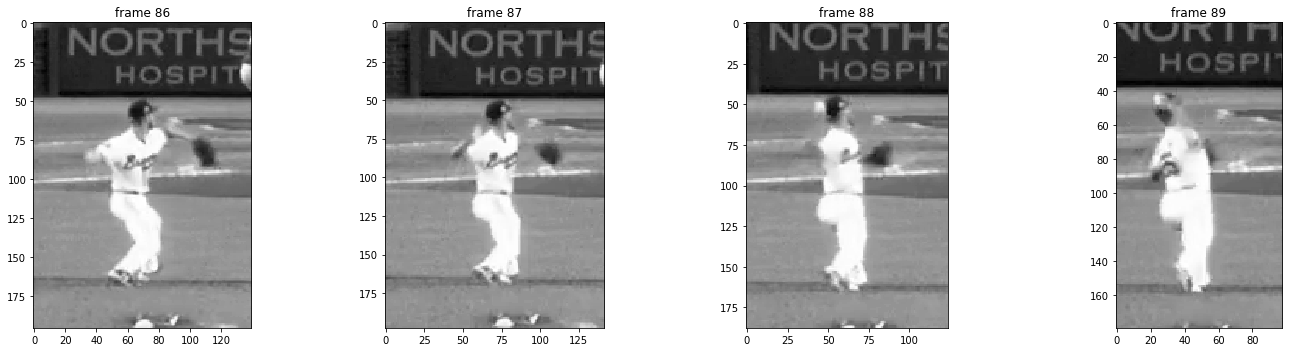

session started
INFO:tensorflow:Restoring parameters from /Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/saved_models/release_model
session restored
end of video capture
---- Image release position approach:  92 --------


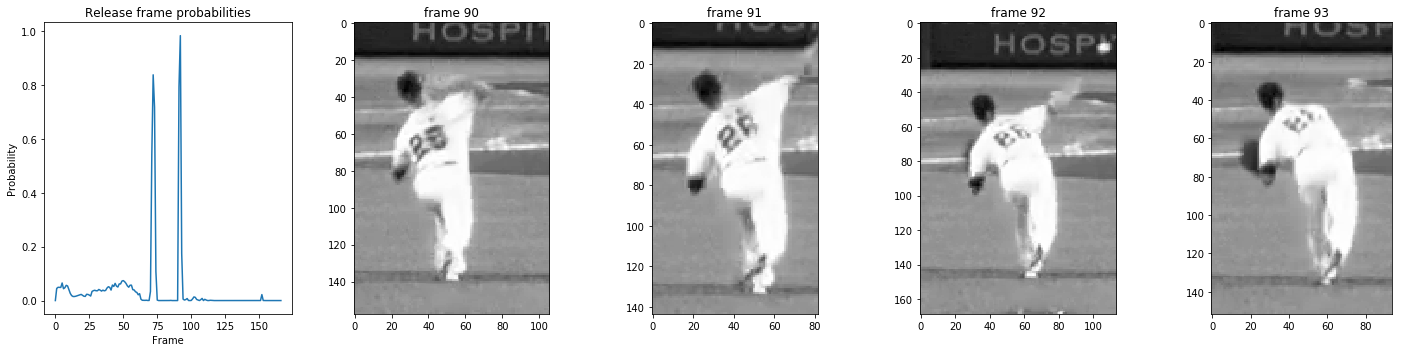

INFO:tensorflow:Restoring parameters from /Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/saved_models/release_model
time for nr labels 0.032217979431152344
---- Release frame from trajectories approach:  0.190059 --------


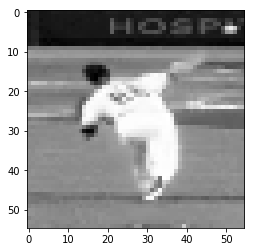

might be a lower value because format of saved videos_p array is different from the normal region of interest, it is recommended to take the first frame with prob >0.1 of a new video as the release frame


In [11]:
# HIGHER SHOULDER RELEASE FRAME

release_higher_shoulder = hs_release(pitcher)


# IMAGE RELEASE POSITION APPROACH (STANCE OF PITCHER RECOGNIZED WITH 2D CNN)

video_file = example+".mp4"

# For the image classification, a region of interest is required / helpful
for i in open(video_file+".dat").readlines():
        datContent=ast.literal_eval(i)        
bottom_p=datContent['Pitcher']['bottom']
left_p=datContent['Pitcher']['left']
right_p=datContent['Pitcher']['right']
top_p=datContent['Pitcher']['top']

box = [left_p, right_p, top_p, bottom_p] # bounding box 

# RU Release unrame from video function
release_from_video, release_probs = release_frame_2Dfrom_video(video_file, bbox = box, model = path_to_models+"release_model")

print("---- Image release position approach: ", release_from_video, "--------")
# Plot
show_frames = range(release_from_video-2, release_from_video+2)
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1,len(show_frames)+1,1)
plt.plot(release_probs)
plt.title("Release frame probabilities")
plt.xlabel("Frame")
plt.ylabel("Probability")
for ind, i in enumerate(show_frames):
    ax = fig.add_subplot(1,len(show_frames)+1,ind+2)
    plt.imshow(videos_p[i])
    plt.gray()
    plt.title("frame "+str(i))
plt.tight_layout()
plt.show()

# FOR SINGLE IMAGE CLASSIFICATION: no extra function, just use test
release_image = np.array(videos_p[release_from_video])
input_release_frame = cv2.resize(release_image,(55, 55), interpolation = cv2.INTER_LINEAR)/255
data = np.reshape(input_release_frame, (1, 55, 55, 1))
lab, out = test(data, path_to_models+"release_model")
release_probability_from_image = out[0,1]
print("---- Release frame from trajectories approach: ", release_probability_from_image, "--------")
plt.imshow(input_release_frame)
plt.show()
print("might be a lower value because format of saved videos_p array is different from the normal region of interest, it is recommended to take the first frame with prob >0.1 of a new video as the release frame")

# Batter's first movement: gradient and neural network method

10 40
INFO:tensorflow:Restoring parameters from /Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/saved_models/batter_first_rnn_10_40
time for nr labels 0.4175410270690918
--------------START RUN: network: 127 , gradient:  <function first_move_gradient at 0x1335571e0> ------------------


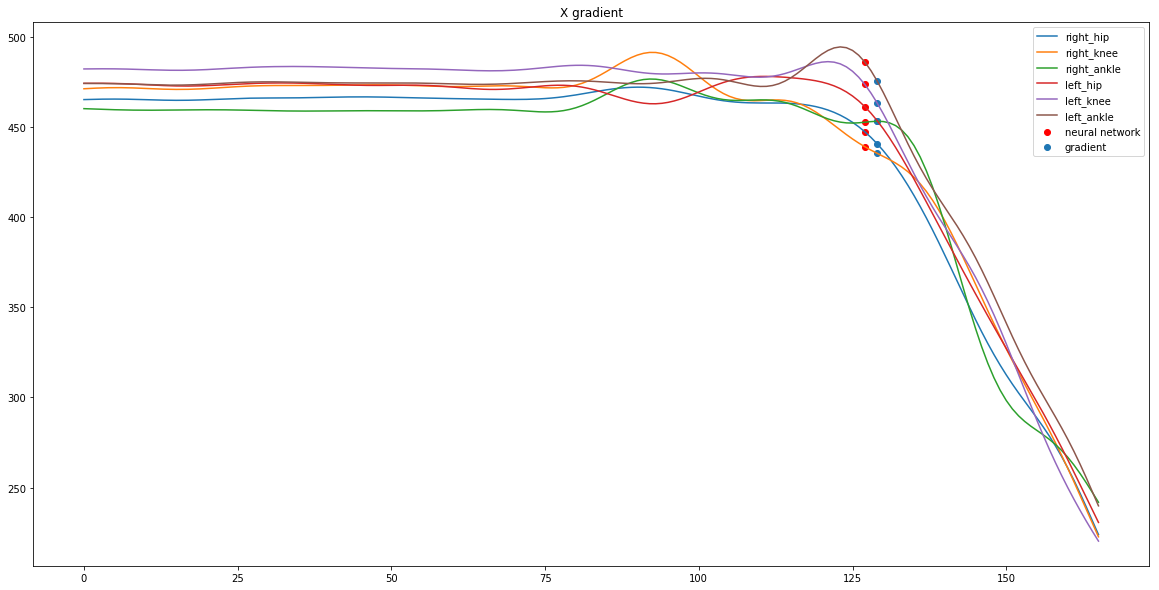

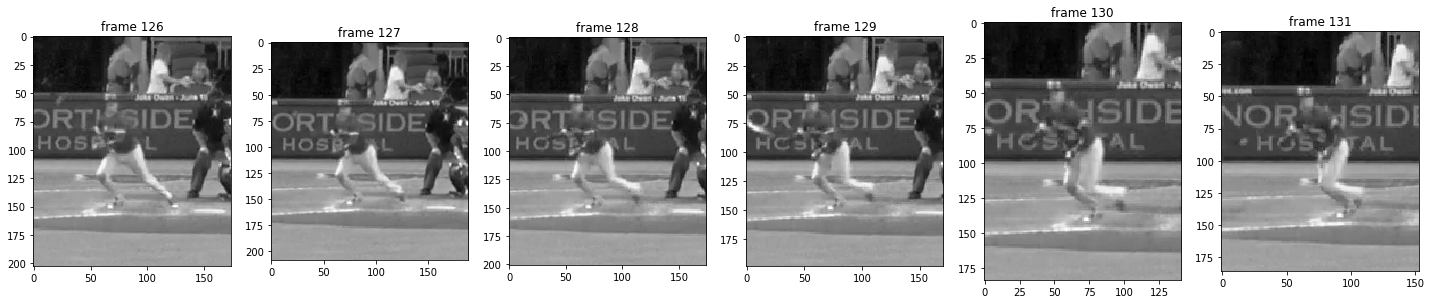

In [13]:
# gradient method
first_batter_gradient = first_move_gradient(batter)
# neural network
first_move_nn = first_move_batter_NN(np.array([batter]), [90], model = path_to_models+ "batter_first_rnn_10_40")[0] # LATER HERE RELEASE FRAME
print("--------------START RUN: network:", first_move_nn, ", gradient: ", first_move_gradient, "------------------")
plt.figure(figsize = (20,10))
for j in joints_list[6:12]:
    plt.plot(batter[:,joints_list.index(j), 0], label = j)
plt.scatter([first_move_nn for _ in range(6)], batter[first_move_nn, 6:12, 0],  label = "neural network", color = "red")
plt.scatter([first_batter_gradient for _ in range(6)], batter[first_batter_gradient, 6:12, 0], label = "gradient")
plt.legend()
plt.title("X gradient")
plt.show()

show_frames = range(first_batter_gradient-3, first_batter_gradient+3)
fig = plt.figure(figsize=(20, 5))
for ind, i in enumerate(show_frames):
    ax = fig.add_subplot(1,len(show_frames),ind+1)
    plt.imshow(videos_b[i])
    plt.gray()
    plt.title("frame "+str(i))
plt.tight_layout()
plt.show()

### Moment batter puts foot down

in function: first step 127 foot highest 91 foot down 100
first step 127 foot highest 91 foot down 100
--------------moment batter puts foot down 100 ------------------


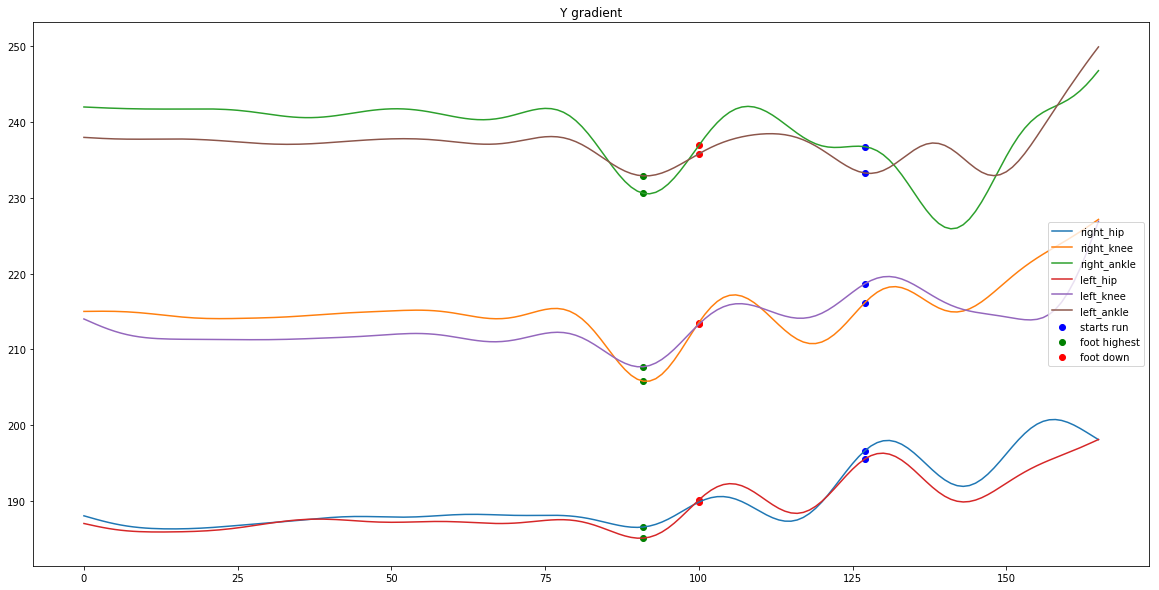

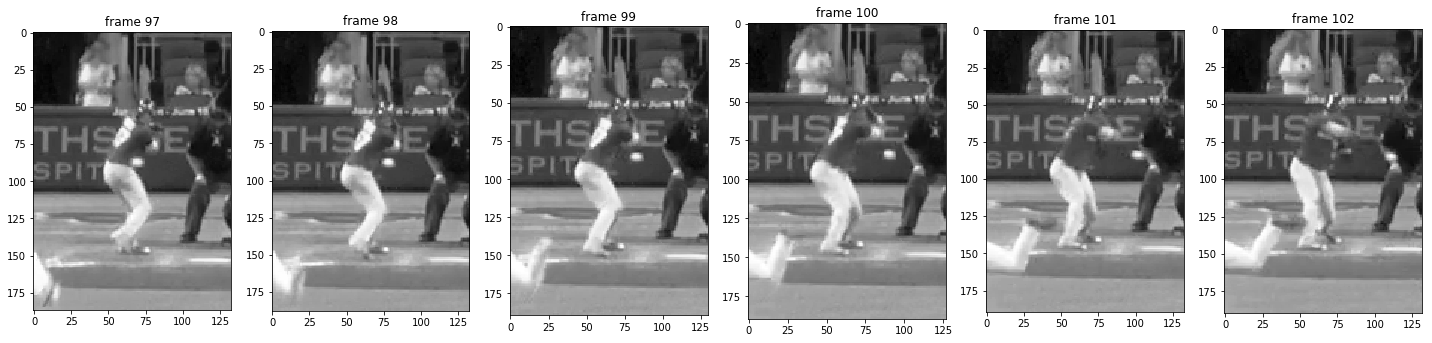

In [14]:
relevant_joints =[7,8,10,11]

foot_up, foot_down_gradient = foot_to_ground(batter, release= release_from_video, start_run = first_move_nn)
    
print("first step", first_move_nn, "foot highest", foot_up, "foot down", foot_down_gradient)

print("--------------moment batter puts foot down", foot_down_gradient, "------------------")
plt.figure(figsize = (20,10))
for j in joints_list[6:12]:
    plt.plot(batter[:,joints_list.index(j), 1], label = j)
plt.scatter([first_move_nn for _ in range(6)], batter[first_move_nn, 6:12, 1],  label = "starts run", color = "blue")
plt.scatter([foot_up for _ in range(6)], batter[foot_up, 6:12, 1],  label = "foot highest", color = "green")
plt.scatter([foot_down_gradient for _ in range(6)], batter[foot_down_gradient, 6:12, 1],  label = "foot down", color = "red")
plt.legend()
plt.title("Y gradient")
plt.show()

show_frames = range(foot_down_gradient-3, foot_down_gradient+3)
fig = plt.figure(figsize=(20, 5))
for ind, i in enumerate(show_frames):
    ax = fig.add_subplot(1,len(show_frames),ind+1)
    plt.imshow(videos_b[i])
    plt.gray()
    plt.title("frame "+str(i))
plt.tight_layout()
plt.show()

# Fast moving object detection - for pitcher's first movement, ball detection and ball release frame

##  Release frame and ball trajectory

works better with side view video, because green background for ball detection

output: 98 [[163.5, 107.0, 98.0], [207.5, 116.5, 99.0], [252.0, 128.5, 100.0], [342.0, 152.5, 102.0], [388.0, 164.5, 103.0], [434.0, 178.5, 104.0], [481.5, 191.5, 105.0], [529.0, 206.0, 106.0], [577.0, 221.0, 107.0], [624.5, 235.5, 108.0], [673.5, 250.5, 109.0]]
The release frame predicted above is correct, althought 98 != 92, because center field camera and side view camera are not synchronized


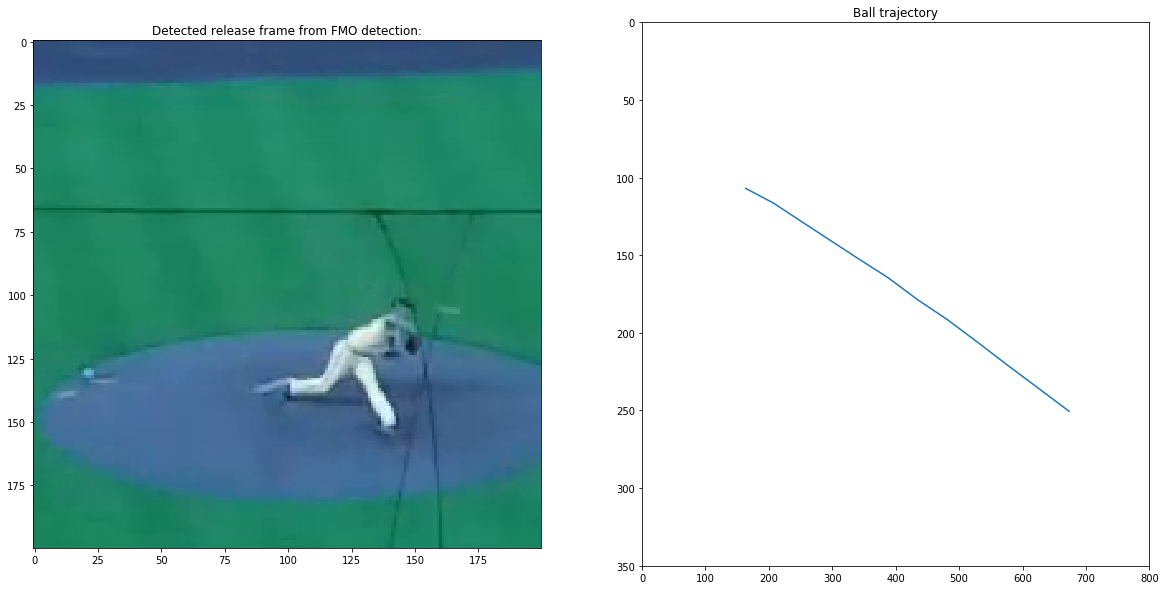

In [6]:
BASE = example+".m4v"
box = [400, 800, 600, 1400]
ball_release, ball_trajectory, _, _ = detect_ball(BASE, joints_array = None, plotting=False, min_area=30, every_x_frame=4, roi=box)
print("output:", ball_release, ball_trajectory.tolist())
print("The release frame predicted above is correct, althought 98 != 92, because center field camera and side view camera are not synchronized")

plt.figure(figsize = (20,10))
cap = cv2.VideoCapture(example+".m4v")
p=0
while True:
    ret, frame = cap.read()
    if p==ball_release:
        plt.subplot(1,2,1)
        plt.imshow(frame[400:600, 600:800])
        plt.title("Detected release frame from FMO detection:")
        break
    p+=1
    
plt.subplot(1,2,2)
plt.plot(ball_trajectory[:,0], ball_trajectory[:,1])
plt.ylim(350, 0)
plt.xlim(0, 800)
plt.title("Ball trajectory")
plt.show()

# Pitcher's first movement:

### with FMO detection and with gradient
FMO detection for pitcher's first movement: better with center field video (and in this notebook only pose estimation for center field video is used)

Definition for pitcher's first movement: highest point of his leg when lifting his leg (then the video can be saved from 10 frames before

changes to fmo detection for release frame:
* joints array used (approach works by looking for FMO detections close to knee/ankle in some consecutive frames)
* bigger min_area used
* no roi required
* every_x_frame = 4 means that only every fourth frame is compared, such that slower movements are detected than for the ball

In [ ]:
BASE = example+".mp4"
MIN_AREA = 40
#tic = time.time()
_, _, first_move_frame, _ = detect_ball(BASE, joints_array = pitcher, plotting=False, min_area=MIN_AREA, every_x_frame=4)
#print("performance is real time: time for 70 frames with plotting:", time.time()-tic)

In [ ]:
# changes to batter: 
# relevant_coordinate: Y coordinate (because lifting of leg) 
# relevant_joints_list: only knees and ankles
relevant_joints =[7,8,10,11]
first_pitcher_gradient = first_move_gradient(pitcher, relevant_joints_list=relevant_joints, relevant_coordinate=1, cutoff=2)


print("--------------START RUN: FMO detection:", first_move_frame, ", gradient: ", first_pitcher_gradient, "------------------")
plt.figure(figsize = (20,10))
for j in np.array(joints_list)[[relevant_joints]]:
    plt.plot(pitcher[:,joints_list.index(j), 1], label = j)
plt.scatter([first_move_frame for _ in range(len(relevant_joints))], pitcher[first_move_frame, relevant_joints, 1],  label = "FMO detection", color = "red")
plt.scatter([first_pitcher_gradient for _ in range(len(relevant_joints))], pitcher[first_pitcher_gradient, relevant_joints, 1], label = "gradient")
plt.legend()
plt.title("Y gradient")
plt.ylim(350, 200)
plt.show()

show_frames = range(first_pitcher_gradient-5, first_pitcher_gradient+1)
fig = plt.figure(figsize=(20, 5))
for ind, i in enumerate(show_frames):
    ax = fig.add_subplot(1,len(show_frames),ind+1)
    plt.imshow(videos_p[i])
    plt.gray()
    plt.title("frame "+str(i))
plt.tight_layout()
plt.show()

# Timeline - all events

In [ ]:
pitcher_events = {"First move (FMO)": first_move_frame, "First move (gradient)": first_pitcher_gradient,
                 "Ball release (FMO- wrong because other video!!)": ball_release, "Ball release (trajectories NN)": release_from_trajectory,
                 "Ball release (NN - position in image)": release_from_video}
batter_events = {"Foot highest": foot_up, "Foot down (gradient)": foot_down_gradient, 
                "First step (gradient)": first_batter_gradient, "First step (trajectories NN)": first_move_nn}
col=["green", "blue","red", "purple","black", "gray", "orange", "yellow", "brown", "pink", "black"]
co = ["x","y"]
# PITCHER
limits = [450, 150]
plt.figure(figsize = (20,10))
for j in [0,1]:
    plt.plot(pitcher[:,:, j], label = co[j], color = col[j])
for i, event in enumerate(list(pitcher_events.keys())):
    plt.plot([pitcher_events[event], pitcher_events[event]], limits, color=col[i+2], label=event)
plt.legend(fontsize=20)
plt.title("Pitcher - Timeline on trajectories", fontsize=20)
plt.ylim(limits[0], limits[1])
plt.ylabel("X/Y value", fontsize=20)
plt.xlabel("Frame index", fontsize=20)
plt.show()

# BATTER foot_up, foot_down_gradient first_move_gradient first_move_nn
limits = [600, 100]
plt.figure(figsize = (20,10))
for j in [0,1]:
    plt.plot(batter[:,:, j], label = co[j], color = col[j])
for i, event in enumerate(list(batter_events.keys())):
    plt.plot([batter_events[event], batter_events[event]], limits, color=col[i+7], label=event)
plt.legend(fontsize=20)
# plt.title("Batter - Timeline on trajectories")
plt.ylim(limits[0], limits[1])
plt.ylabel("X/Y value", fontsize=20)
plt.xlabel("Frame index", fontsize=20)
plt.show()

In [ ]:
limbSeq = [[2,3], [2,6], [3,4], [4,5], [6,7], [7,8], [2,9], [9,10], \
           [10,11], [2,12], [12,13], [13,14], [2,1], [1,15], [15,17], \
           [1,16], [16,18], [3,17], [6,18]]
pitcher_array = np.roll(pitcher, 2, axis = 1)
batter_array = np.roll(batter, 2, axis = 1)

In [ ]:
cap = cv2.VideoCapture("/Volumes/Nina Backup/high_quality_testing/pitcher/#42 LHP Michael Chavez.mp4") #26 RHP Tim Willites (2).mp4") #example+".mp4")
cap.set(cv2.CAP_PROP_POS_FRAMES, 470)
_, canvas = cap.read()
plt.figure(figsize=(20,10))
plt.imshow(canvas)
plt.savefig("canvas")
plt.show()

In [ ]:
import math
limbSeq = [[0,1], [1,2], [0,3], [3,4], [4,5], [6,9],[6,7], [7,8],[9,10],[10,11], [0,6], [3,9]]
stickwidth = 8
colors = [[255, 0, 0], [120, 0, 0], [255, 255, 0], [255, 120, 0], [200, 100, 0], [120, 120, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
cap = cv2.VideoCapture("/Volumes/Nina Backup/high_quality_testing/pitcher/#42 LHP Michael Chavez.mp4") #26 RHP Tim Willites (2).mp4") #example+".mp4")
cap.set(cv2.CAP_PROP_POS_FRAMES, 470)
_, canvas = cap.read()
canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
pitcher = from_json("/Volumes/Nina Backup/low_quality_testing/scale0tests/#42 LHP Michael Chavez.json")
plt.figure(figsize =(20,10))
ball_trajectory = [[479, (525, 241), (568, 282)], [480, (416, 245), (451, 280)], [481, (304, 241), (344, 272)], 
                   [482, (176, 235), (224, 272)], [483, (56, 229), (104, 262)]]
frame_list = [0, 400, 450, 490]
for j in range(len(pitcher)):
    if j >=ball_trajectory[0][0] and j<=ball_trajectory[-1][0]:
        cand = ball_trajectory[j-ball_trajectory[0][0]]
        cv2.rectangle(canvas, cand[1], cand[2],[255,0,0], 4)
    if j in frame_list:
        for player in ["pitcher"]:
            for i, inds in enumerate(limbSeq):
                if inds[0]>11 or inds[1]>11:
                    continue
                Y = eval(player)[j,inds, 0]
                X = eval(player)[j,inds, 1]
                mX = np.mean(X)
                mY = np.mean(Y)
                cur_canvas = canvas.copy()
                length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
                angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
                polygon = cv2.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
                cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
                canvas = cv2.addWeighted(canvas, 0.1, cur_canvas, 0.9, 0)
plt.imshow(canvas)
plt.show()